In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 46)

In [3]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']

columns_cat = ['display_env',
            'target_env',
            'campaignscenario',
            'campaignvertical',
            'is_interstitial',
            'device_type']

X_quant = df[columns_quant]
X_quant_scaled = StandardScaler().fit_transform(X_quant)
print(len(X_quant.columns))
display(X_quant.columns)

X_cat = df[columns_cat]
X_cat = pd.get_dummies(X_cat, columns=columns_cat, drop_first=True)
X_cat_scaled = StandardScaler().fit_transform(X_cat)
print(len(X_cat.columns))
display(X_cat.columns)

X_quant_cat = df[columns_quant + columns_cat]
X_quant_cat = pd.get_dummies(X_quant_cat, columns=columns_cat, drop_first=True)
X_quant_cat_scaled = StandardScaler().fit_transform(X_quant_cat)
print(len(X_quant_cat.columns))
display(X_quant_cat.columns)

y = df['is_display_clicked']

13


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')

21


Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone'],
      dtype='object')

34


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro', 'display_env_app_ios', 'display_env_other',
       'display_env_web', 'target_env_2', 'campaignscenario_5',
       'campaignscenario_6', 'campaignscenario_11', 'campaignscenario_12',
       'campaignscenario_13', 'campaignscenario_17', 'campaignvertical_20.0',
       'campaignvertical_23.0', 'campaignvertical_129.0',
       'campaignvertical_200002.0', 'is_interstitial_True',
       'device_type_Desktop', 'device_type_Desktop - Safari',
       'device_type_Mobile - Other', 'device_type_Unknown', 'device_type_iPad',
       'device_type_iPhone'],
      dtype='object')

In [4]:
class Modelisation():
    def __init__(self, X, y, model, scaling=True):
        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        probs = model.predict_proba(X_test)[:, 1]
        
        TP = cm[1][1]
        FN = cm[0][1]
        FP = cm[1][0]
        TN = cm[0][0]
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        # Recall
        Recall = TP/(TP+FN)
        # Precision
        Precision = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # F1_Score
        F1 = (2*Precision*Recall)/(Precision+Recall)

        metrics_score = {'f1': F1, 'recall': Recall,'negative predictive value': NPV,'precision': Precision, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
        self.recall = Recall

    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()     
    
    def show_metrics_score(self):
        for key, value in self.metrics_score.items():
            print(f"{key} : {value:.4f}")
            
    def show_ROC(self):
        fpr, tpr, _ = metrics.roc_curve(self.y_test, self.probs)
        plt.plot(fpr, tpr, label=f"{self.model}")
        plt.plot([0, 1], [0, 1], "r-", label='Modèle aléatoire')
        plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Modèle parfait')
        plt.legend()
        plt.title('Courbe ROC')
        plt.show()
    
    def show_recall(self): 
        return self.recall

Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

## Variables quantitatives

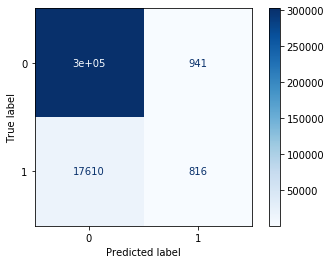

f1 : 0.0809
recall : 0.4644
negative predictive value : 0.9969
precision : 0.0443
roc_auc : 0.7352


In [5]:
m = Modelisation(X_quant, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

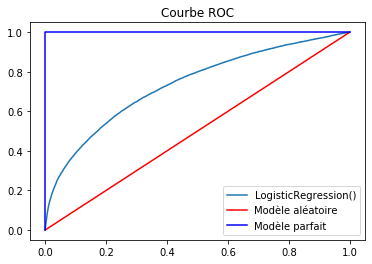

In [6]:
m.show_ROC()

In [7]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.023131
campaignctrlast24h,0.362024
dayssincelastvisitdouble,-0.022458
ltf_nbglobaldisplay_4w,0.010258
ltf_nbpartnerdisplayssincelastclick,-0.028631
ltf_nbpartnerdisplay_90d,-0.011365
ltf_nbpartnerclick_90d,0.031878
ltf_nbpartnersales_90d,-0.009116
nbdayssincelastclick,-0.110676
nbdisplay_1hour,-0.223872


In [8]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ = add_constant(X_quant)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610480
Method:                           MLE   Df Model:                           13
Date:                Thu, 28 Jan 2021   Pseudo R-squ.:                 0.09804
Time:                        10:41:41   Log-Likelihood:            -3.1747e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7845      0.0

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [9]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

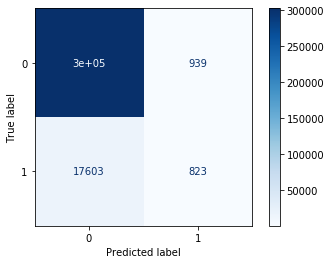

f1 : 0.0815
recall : 0.4671
negative predictive value : 0.9969
precision : 0.0447
roc_auc : 0.7350


In [10]:
m1 = Modelisation(X1, y1, LogisticRegression())
m1.show_conf_matrix()
m1.show_metrics_score()

# Categorical variables

In [11]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7


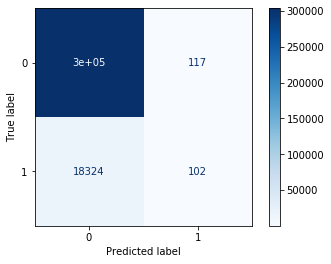

f1 : 0.0109
recall : 0.4658
negative predictive value : 0.9996
precision : 0.0055
roc_auc : 0.6820


In [12]:
m = Modelisation(X_cat, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

## Quantitative + categorical

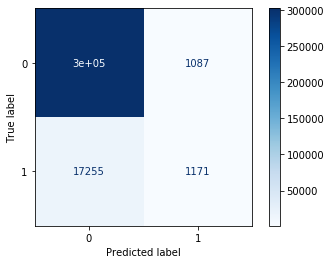

f1 : 0.1132
recall : 0.5186
negative predictive value : 0.9964
precision : 0.0636
roc_auc : 0.7514
Wall time: 10.1 s


In [13]:
%%time
m = Modelisation(X_quant_cat, y, LogisticRegression())
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [14]:
X2 = X_quant_cat[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]
y2 = df['is_display_clicked']

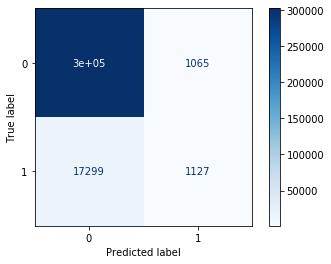

f1 : 0.1093
recall : 0.5141
negative predictive value : 0.9965
precision : 0.0612
roc_auc : 0.7485
Wall time: 5.2 s


In [15]:
%%time
m2 = Modelisation(X2, y2, LogisticRegression())
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

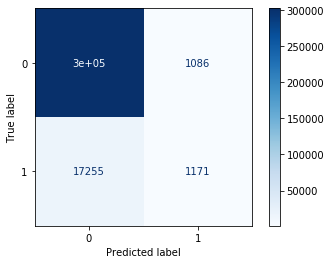

f1 : 0.1132
recall : 0.5188
negative predictive value : 0.9964
precision : 0.0636
roc_auc : 0.7514


In [16]:
m = Modelisation(X_quant_cat, y, LogisticRegression(C=0.2))
m.show_conf_matrix()
m.show_metrics_score()

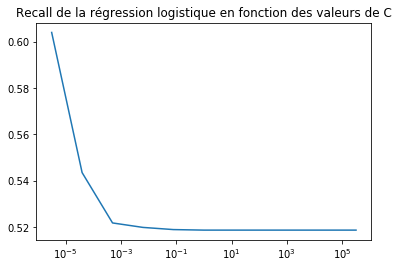

In [17]:
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num = 11): 
    m = Modelisation(X_quant_cat, y, LogisticRegression(C=c))
    C.append(c)
    list_recall.append(m.show_recall())
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

In [18]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:03:20
